# Prediction Modeling
### with 100M Grid Density/Census data

In [30]:
import geopandas as gpd
import pandas as pd
from pycaret.regression import *
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
import os
os.chdir('/Users/dangchan/Desktop/Github/LocalSecurity_competition')

In [2]:
# Load files : grid, kderesult, census data
grid = gpd.read_file('data/CENSUS/grid_DJ_100M.gpkg')
density = pd.read_csv('SKDE/result/DJ_100M_sb_1179.csv')
census = gpd.read_file('df_full_100M.gpkg').fillna(0)

result_grid = density.groupby(['X','Y'], as_index=False).sum()
result_grid = gpd.GeoDataFrame(result_grid['density'], geometry=gpd.points_from_xy(result_grid.X, result_grid.Y), crs='epsg:5181')

# 격자에 병합
grid = grid.sjoin(result_grid, how='left')
grid = grid[grid.columns.drop('index_right')]
grid.density = (grid.density - grid.density.mean()) / grid.density.std() # normalize target density

# census data
df = grid.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)
df = df[df.columns.drop('geometry')]

In [3]:
reg = setup(
    data=df, target="density", session_id=123,
    transformation=True, normalize=True, numeric_imputation='mode',
    remove_multicollinearity=True, multicollinearity_threshold=0.95,
)

,Description,Value
0,Session id,123
1,Target,density
2,Target type,Regression
3,Data shape,"(54910, 13)"
4,Train data shape,"(38436, 13)"
5,Test data shape,"(16474, 13)"
6,Numeric features,14
7,Preprocess,True
8,Imputation type,simple
9,Numeric imputation,mode


In [4]:
reg.compare_models(errors='raise')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.4360,0.4745,0.6885,0.5262,0.2710,2.3761,0.1490
lightgbm,Light Gradient Boosting Machine,0.4357,0.4779,0.6910,0.5228,0.2711,2.4201,0.0610
catboost,CatBoost Regressor,0.4376,0.4853,0.6963,0.5155,0.2726,2.4122,0.8810
rf,Random Forest Regressor,0.4412,0.4985,0.7057,0.5023,0.2770,2.4366,0.2520
xgboost,Extreme Gradient Boosting,0.4423,0.5018,0.7081,0.4989,0.2761,2.4133,0.4190
knn,K Neighbors Regressor,0.4536,0.5155,0.7177,0.4853,0.2829,2.4739,0.3800
lr,Linear Regression,0.4584,0.5190,0.7201,0.4818,0.2807,2.4135,0.2690
ridge,Ridge Regression,0.4584,0.5190,0.7201,0.4818,0.2807,2.4135,0.0230
lar,Least Angle Regression,0.4584,0.5190,0.7201,0.4818,0.2807,2.4135,0.0210
br,Bayesian Ridge,0.4585,0.5190,0.7201,0.4818,0.2807,2.4125,0.0280


GradientBoostingRegressor(random_state=123)

In [5]:
gbr = reg.create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4337,0.4870,0.6978,0.4898,0.2727,1.5710
1,0.4294,0.4477,0.6691,0.5723,0.2676,5.3224
2,0.4290,0.4506,0.6713,0.5475,0.2655,1.5442
3,0.4541,0.5252,0.7247,0.4962,0.2802,2.3689
4,0.4409,0.4844,0.6960,0.5280,0.2715,1.8595
5,0.4207,0.4261,0.6527,0.5605,0.2594,1.7674
6,0.4388,0.4695,0.6852,0.5129,0.2731,1.4515
7,0.4351,0.4615,0.6793,0.5116,0.2676,1.9100
8,0.4333,0.4737,0.6883,0.5219,0.2714,2.6963


In [6]:
tuned_gbr = reg.tune_model(gbr, search_library='scikit-optimize')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4344,0.4861,0.6972,0.4907,0.2745,1.5557
1,0.4309,0.4472,0.6687,0.5727,0.2696,5.3073
2,0.4299,0.4504,0.6711,0.5477,0.2676,1.5878
3,0.4551,0.5252,0.7247,0.4962,0.2823,2.4235
4,0.4418,0.4845,0.6960,0.5280,0.2735,1.8620
5,0.4216,0.4248,0.6518,0.5618,0.2607,1.7482
6,0.4396,0.4688,0.6847,0.5136,0.2746,1.4465
7,0.4357,0.4611,0.6790,0.5121,0.2698,1.9120
8,0.4343,0.4721,0.6871,0.5236,0.2739,2.6844


In [11]:
plot_model(tuned_gbr, plot='parameter')

,Parameters
alpha,0.9
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.0238190072917794
loss,squared_error
max_depth,3
max_features,0.4284489606984907
max_leaf_nodes,None
min_impurity_decrease,0.002646746704757545


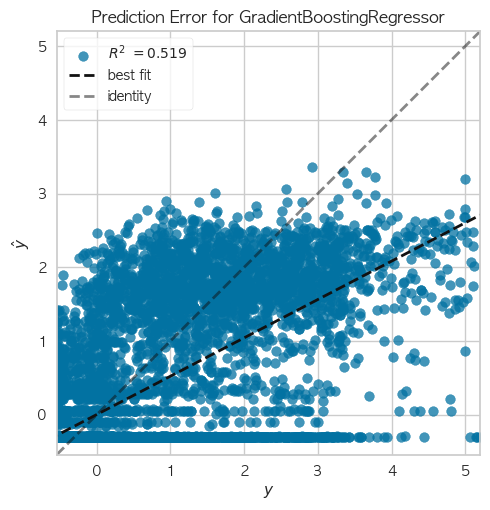

In [12]:
plot_model(tuned_gbr, 'error')

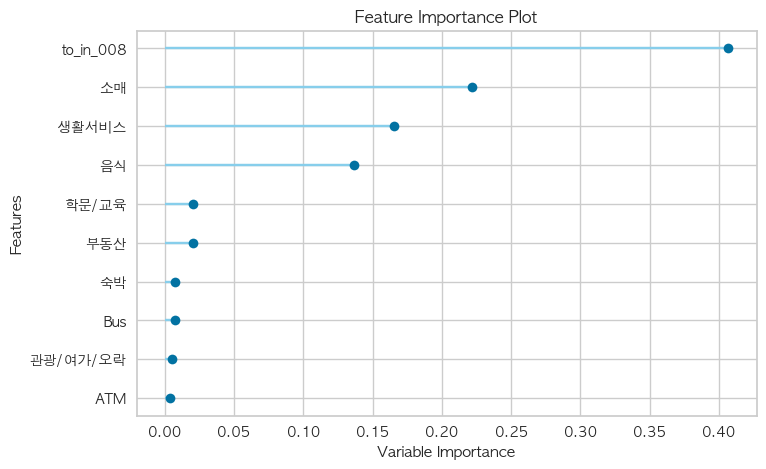

In [13]:
plot_model(tuned_gbr, 'feature') # 격자당 여성인구(to_in_008) 

## Prediction

In [14]:
# Load files : grid, kderesult, census data
grid_SJ = gpd.read_file('data/CENSUS/grid_SJ_100M.gpkg')
census = gpd.read_file('df_full_100M.gpkg').fillna(0)

# census data
df_predict = grid_SJ.set_index('GRID_100M_').join(census[census.columns.drop('geometry')].set_index('GRID_100M_')).reset_index(drop=True)
df_predict = df_predict[df_predict.columns.drop('geometry')]

In [15]:
df_predict = predict_model(tuned_gbr, data=df_predict)

In [16]:
grid_SJ['density'] = df_predict['prediction_label']

In [24]:
grid_SJ.density = (grid_SJ.density - grid_SJ.density.mean()) / grid_SJ.density.std()

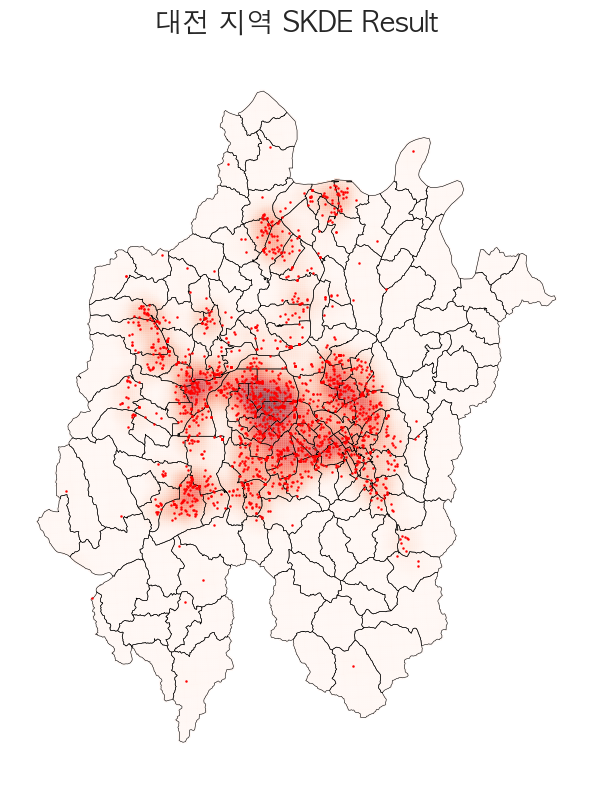

In [26]:
daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949').to_crs(epsg=5181)
crime_daejeon = gpd.read_file('data/gdf_crime_adm_DJ.gpkg').to_crs(epsg=5181)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
daejeon.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.4)
grid.plot(column = 'density',ax=ax, zorder=1, cmap='Reds', alpha=0.7)
crime_daejeon.geometry.plot(ax=ax, zorder=3, color='red', markersize=2)

ax.set_axis_off()

plt.suptitle('대전 지역 SKDE Result', fontsize=20)
plt.tight_layout()
plt.show()

TypeError: show() got an unexpected keyword argument 'transparent'

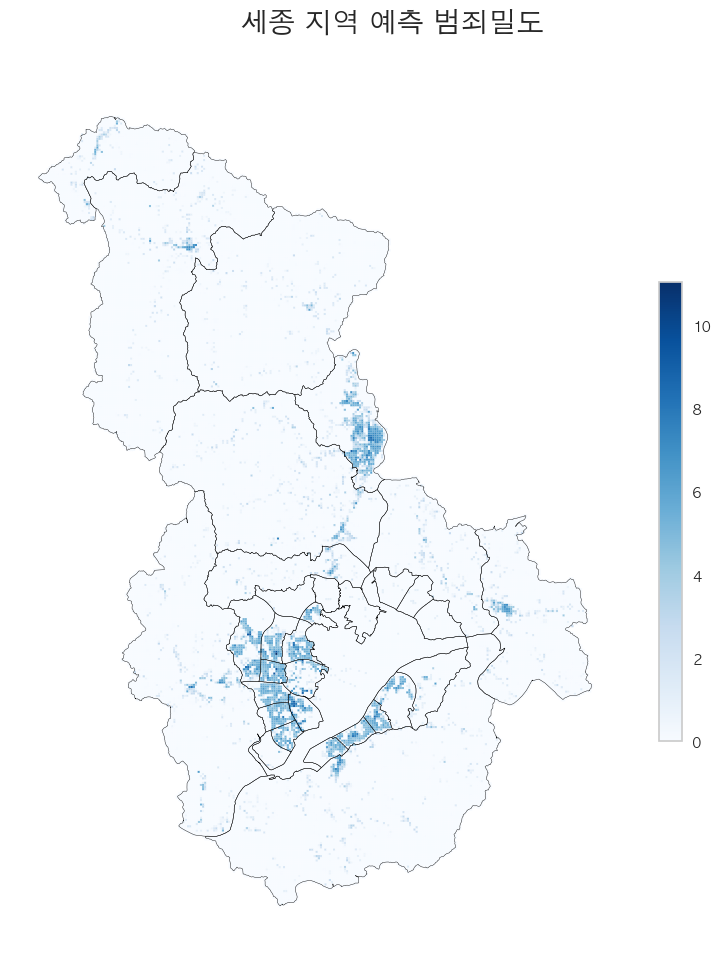

In [29]:
# Prediction map
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949').to_crs(epsg=5181)
crime_sejong = gpd.read_file('data/gdf_crime_adm_SJ.gpkg')
grid_SJ['density'] = grid_SJ['density'] - grid_SJ.density.min() # for better plotting

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
sejong.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.3)
grid_SJ.plot(column = 'density',ax=ax, zorder=1, cmap='Blues', legend=True, legend_kwds={'shrink' : 0.5})
# crime_sejong.geometry.plot(ax=ax, zorder=3, color='red', markersize=1)

ax.set_axis_off()

plt.suptitle('세종 지역 예측 범죄밀도', fontsize=20)
plt.tight_layout()
plt.show()

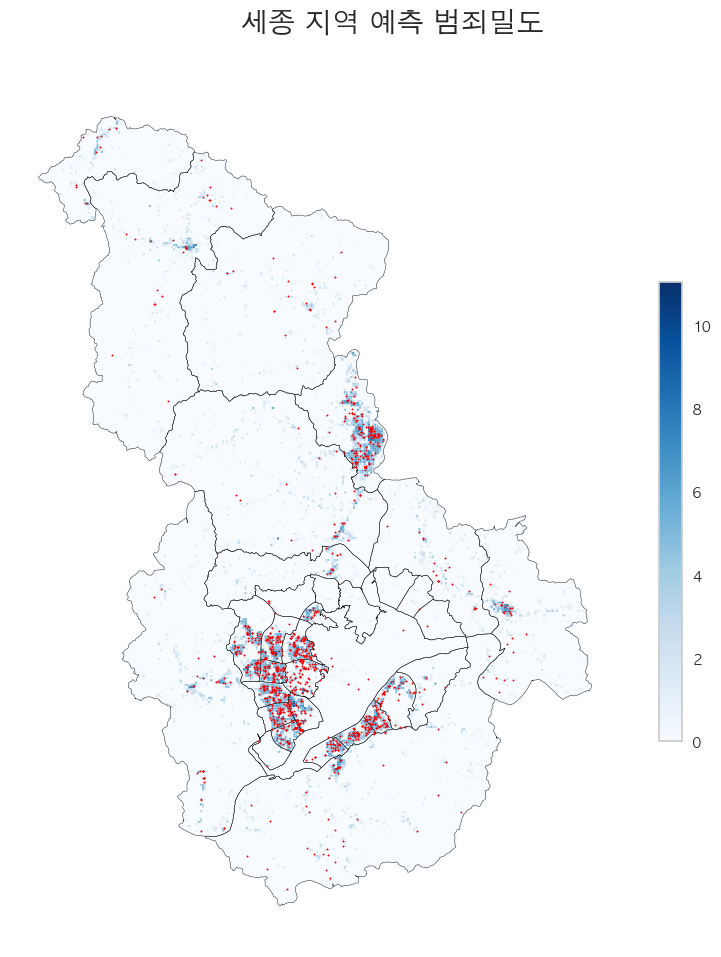

In [28]:
# Prediction map
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949').to_crs(epsg=5181)
crime_sejong = gpd.read_file('data/gdf_crime_adm_SJ.gpkg')
grid_SJ['density'] = grid_SJ['density'] - grid_SJ.density.min() # for better plotting

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
sejong.boundary.plot(ax=ax, zorder=2, color='black', linewidth = 0.3)
grid_SJ.plot(column = 'density',ax=ax, zorder=1, cmap='Blues', legend=True, legend_kwds={'shrink' : 0.5})
crime_sejong.geometry.plot(ax=ax, zorder=3, color='red', markersize=1)

ax.set_axis_off()

plt.suptitle('세종 지역 예측 범죄밀도', fontsize=20)
plt.tight_layout()
plt.show()

## Accuracy
전체 세종시 보이스피싱 범죄 $1422$건 중 $1137$건이 density prediction으로 얻어진 격자($N=5982$)에 포함됨</br>
오차 포함시(격자 중심부(`centroid`)로부터 $100$m 이내) 총 $1310$건
$$
Recall \simeq 0.8 \;\; (0.92\;\text{if 200m error})
$$

In [20]:
plus_densities = grid_SJ[grid_SJ.density > 0]
len(plus_densities)

5982

In [21]:
crime_grid_idx = crime_sejong.sjoin(grid_SJ)['index_right']
len(crime_grid_idx) # 전체 범죄 수

1422

In [22]:
sum([i in plus_densities.index for i in crime_grid_idx])

1137

In [23]:
contained = 0
for i in range(len(crime_sejong)):
    arr = np.where(plus_densities.centroid.distance(crime_sejong.geometry[i]) < 100)[0]
    if len(arr) > 0:
        contained += 1
print(contained)

1310


(-1.0, 20.0)

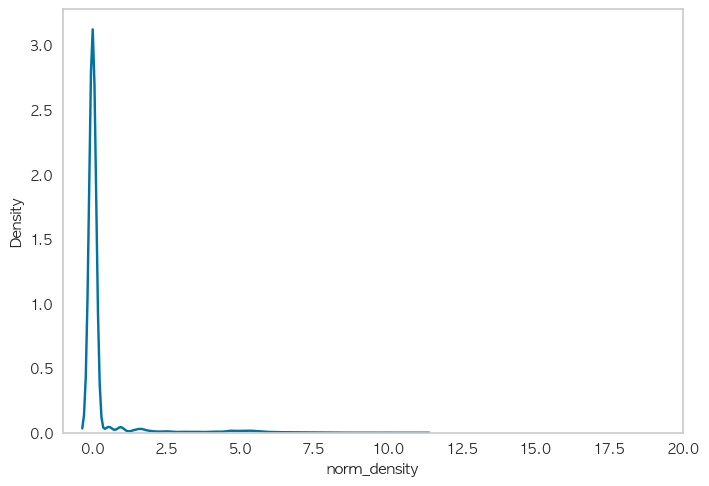

In [33]:
sns.kdeplot(grid_SJ.density)
plt.xlabel('norm_density')
plt.grid(visible=False)
plt.xlim([-1,20])